In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns
import numpy as np

In [29]:
data_folder = "../data"
model_folder = "../models"
train_file = "train_data.csv"
train_data = pd.read_csv(os.path.join(data_folder, train_file))
np.random.seed(2308723)
random_state = 84738

In [3]:
train_data.head()

,mu_ip,sigma_ip,kurtosis_ip,skewness_ip,mu_dmsnr,sigma_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
0,119.070312,54.464321,0.082501,-0.167191,0.617893,9.939801,19.553781,429.015329,0
1,89.687500,43.502110,0.437278,0.466080,5.973244,31.325766,5.831691,34.735606,0
2,108.765625,43.813612,0.251548,0.227560,2.653846,20.597689,8.887964,84.319531,0
3,76.492188,38.122745,0.750549,2.556619,3.250000,22.389197,7.711294,62.916367,0
4,97.007812,49.176579,0.574170,0.269369,104.935619,99.374734,0.053575,-1.779702,0


In [4]:
X_train = train_data.values[:, :-1]
y_train = train_data.values[:, -1]

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(X_train.shape)
X_train_pca = pca.fit_transform(X_train)

(14318, 8)


# SVM Classifiers (Linear & RBF)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

We'll compare linear and RBF SVM classifiers. Data didn't look linearly separable in data exploration so we expect RBF kernel to be better.

In [25]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings("ignore")

svc = SVC(random_state=random_state, max_iter=10000)
grid_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': ["balanced", None], 
              'kernel': ['linear', 'rbf']}
svc = GridSearchCV(svc, grid_params, scoring=['f1_weighted', 'accuracy'], cv=5, refit='f1_weighted')
svc.fit(X_train_scaled, y_train);

In [55]:
def dict_to_str(d):
    s = ""
    for key, item in d.items():
        s += f'{key}: {str(item)}; '
    return s

def get_cv_df(cv_clf):
    cv_res_df = pd.DataFrame()
    cv_res_df['params'] = list(map(dict_to_str, cv_clf.cv_results_['params']))
    cv_res_df['mean_test_f1_weighted'] = cv_clf.cv_results_['mean_test_f1_weighted']
    cv_res_df['mean_test_accuracy'] = cv_clf.cv_results_['mean_test_accuracy']
    return cv_res_df

cv_res_df = get_cv_df(svc)

In [56]:
cv_res_df.sort_values(['mean_test_f1_weighted', 'mean_test_accuracy'], ascending=False).head(20)

,params,mean_test_f1_weighted,mean_test_accuracy
19,C: 10; class_weight: None; kernel: rbf;,0.979783,0.980304
23,C: 100; class_weight: None; kernel: rbf;,0.978814,0.979327
14,C: 1; class_weight: None; kernel: linear;,0.978598,0.979257
18,C: 10; class_weight: None; kernel: linear;,0.978450,0.979047
10,C: 0.1; class_weight: None; kernel: linear;,0.977630,0.978419
15,C: 1; class_weight: None; kernel: rbf;,0.977589,0.978279
27,C: 1000; class_weight: None; kernel: rbf;,0.976238,0.976673
13,C: 1; class_weight: balanced; kernel: rbf;,0.975729,0.975276
21,C: 100; class_weight: balanced; kernel: rbf;,0.975677,0.975346
11,C: 0.1; class_weight: None; kernel: rbf;,0.975419,0.976463


Turns out RBF is better than linear kernel, but only very very slightly. Weighted classes seems to be consistently worse than no weights. Extreme values for C are worse than C being around 1 or 10

In [30]:
svc_clf = svc.best_estimator_
from joblib import dump, load
dump(svc_clf, os.path.join(model_folder, "svc.joblib"))

['../models\\svc.joblib']

In [31]:
svc.best_score_

0.9797827316800426

In [78]:
svm_predictions = svc_clf.predict(X_train_scaled)
support_vectors = svc_clf.support_vectors_
support_vectors_pca = pca.transform(support_vectors)

In [40]:
def results(predictions, targets):
    def compare(x, y):
        if x == 1 and y == 1:
            return "true positive"
        elif x == 0 and y == 0:
            return "true negative"
        elif x == 1 and y == 0:
            return "false positive"
        else: 
            return "false negative"
    func = np.vectorize(compare)
    return func(predictions, targets)

true negative     12947
true positive      1109
support vector      753
false negative      202
false positive       60
Name: result, dtype: int64


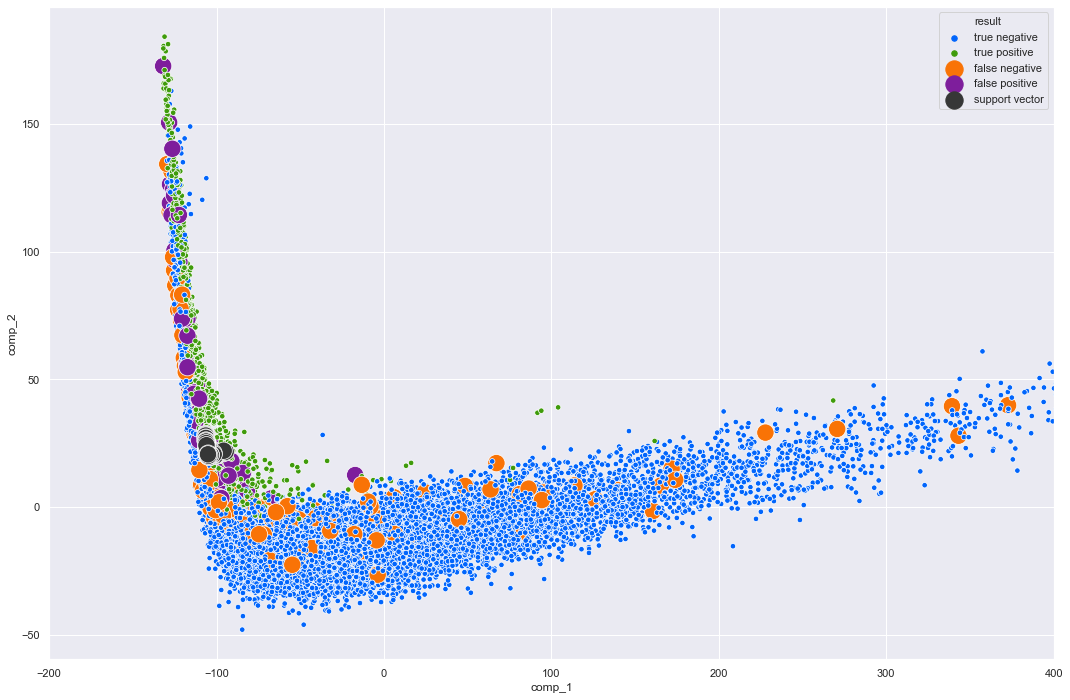

In [79]:
def plot_results_2d(predictions, support_vectors=None):
    results_df = pd.DataFrame()
    results_df["comp_1"] = X_train_pca[:, 0]
    results_df["comp_2"] = X_train_pca[:, 1]
    results_df["result"] = results(predictions, y_train)

    colors = ["bright blue", "grass green", "orange", "purple"]
    my_palette = list(map(lambda x: sns.xkcd_rgb[x], colors))
    sizes = [30, 30, 300, 300]
    
    if support_vectors is not None:
        my_palette.append(sns.xkcd_rgb["dark grey"])
        sizes.append(300)
        
        sv_df = pd.DataFrame()
        sv_df["comp_1"] = support_vectors[:, 0]
        sv_df["comp_2"] = support_vectors[:, 1]
        sv_df["result"] = "support vector"
        results_df = pd.concat([results_df, sv_df])
        
    print(results_df["result"].value_counts())
    
    sns.set(rc={'figure.figsize':(18, 12)})
    sns.scatterplot(x="comp_1", y="comp_2", hue="result", size="result",
                    sizes=sizes, palette=my_palette, data=results_df)
    plt.xlim(-200, 400)
    
plot_results_2d(svm_predictions, support_vectors_pca)
plt.savefig("predictions/rbf_svm_predictions.png")

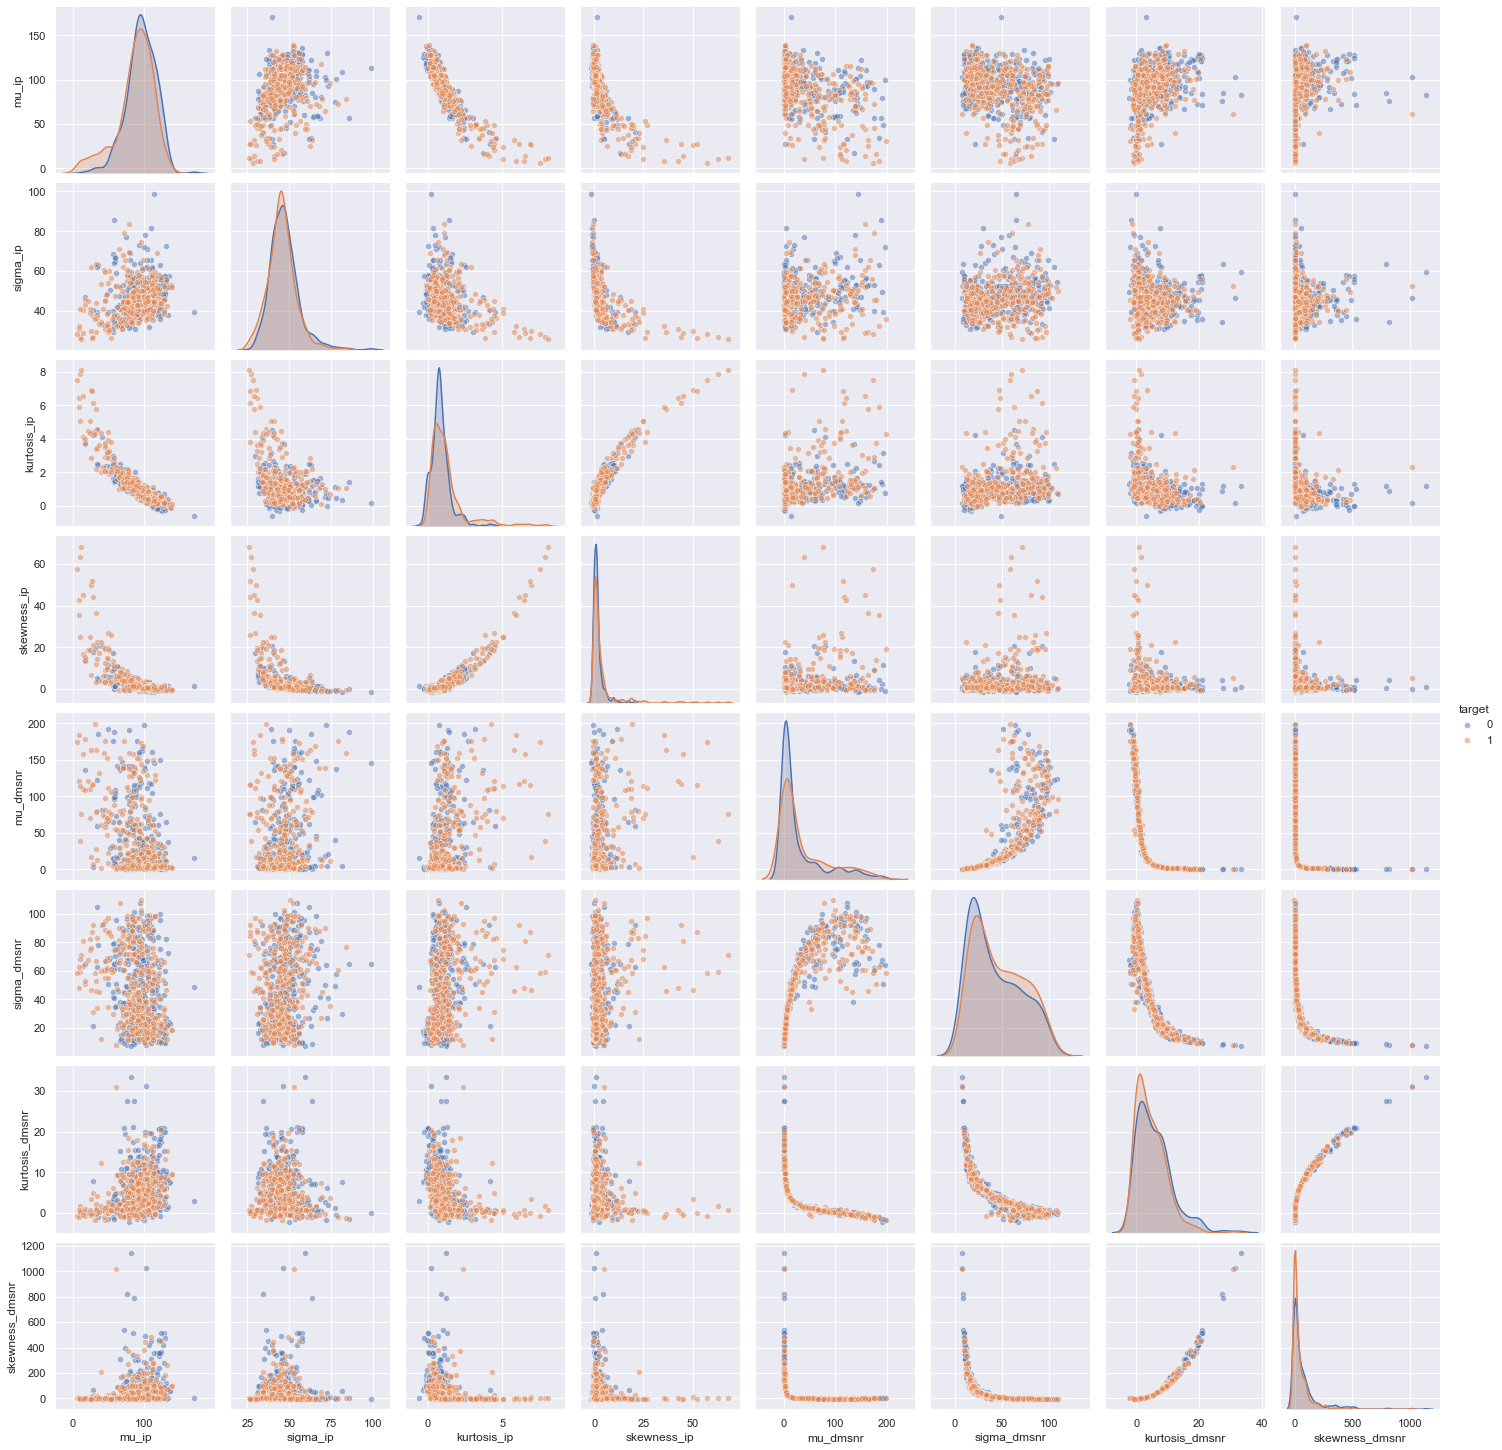

In [47]:
support_vectors = train_data.iloc[svc_clf.support_, :]
sns.pairplot(support_vectors, hue="target", plot_kws={'alpha':0.5});

In [46]:
support_vectors["target"].value_counts()

0    391
1    362
Name: target, dtype: int64

In [35]:
sum(predictions)

1169.0

In [36]:
sum(y_train)

1311.0

# Logistic Regression Classifier

In [69]:
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("default")

lreg = LogisticRegression(random_state=random_state, solver="saga")
params = {"penalty": ["l2", "elasticnet"], 
         'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'class_weight': ["balanced", None],
          'l1_ratio': [0.1, 0.3, 0.5, 0.8, 1]}
lreg_cv = GridSearchCV(lreg, params, cv=5, scoring=['f1_weighted', 'accuracy'], n_jobs=-1, refit="f1_weighted", verbose=5)
lreg_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   34.6s finished
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\ribau\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=84738, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.8, 1],
                         'penalty': ['l2', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit='f1_weighted',
             return_train_score=False, scorin

In [70]:
lreg_cv.best_score_

0.9785914464407395

In [71]:
lreg_cv_df = get_cv_df(lreg_cv)
pd.set_option('max_colwidth', 400)
lreg_cv_df.sort_values(['mean_test_f1_weighted', 'mean_test_accuracy'], ascending=False)

,params,mean_test_f1_weighted,mean_test_accuracy
90,C: 10; class_weight: None; l1_ratio: 0.1; penalty: l2;,0.978591,0.979187
91,C: 10; class_weight: None; l1_ratio: 0.1; penalty: elasticnet;,0.978591,0.979187
92,C: 10; class_weight: None; l1_ratio: 0.3; penalty: l2;,0.978591,0.979187
93,C: 10; class_weight: None; l1_ratio: 0.3; penalty: elasticnet;,0.978591,0.979187
94,C: 10; class_weight: None; l1_ratio: 0.5; penalty: l2;,0.978591,0.979187
...,...,...,...
11,C: 0.001; class_weight: None; l1_ratio: 0.1; penalty: elasticnet;,0.953567,0.958793
13,C: 0.001; class_weight: None; l1_ratio: 0.3; penalty: elasticnet;,0.950122,0.956209
15,C: 0.001; class_weight: None; l1_ratio: 0.5; penalty: elasticnet;,0.945127,0.952577
17,C: 0.001; class_weight: None; l1_ratio: 0.8; penalty: elasticnet;,0.937997,0.947618


In [72]:
lreg_cv_df['mean_test_f1_weighted'].mean()

0.9713253244417944

In [74]:
svc.best_score_

0.9797827316800426

In [105]:
dump(lreg_cv.best_estimator_, os.path.join(model_folder, "log_reg.joblib"))

['../models\\log_reg.joblib']

Logistic regression is just a tiny bit less effective than RBF-SVM.

true negative     12937
true positive      1085
false negative      226
false positive       70
Name: result, dtype: int64


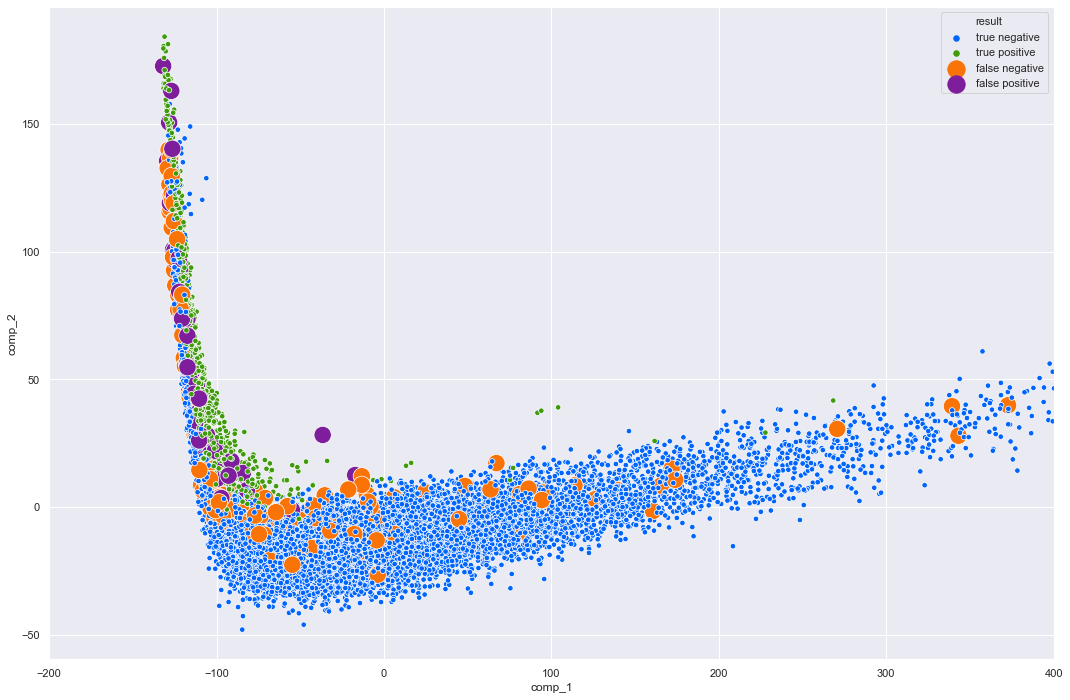

In [80]:
lreg_predictions = lreg_cv.best_estimator_.predict(X_train_scaled)
plot_results_2d(lreg_predictions)
plt.savefig("predictions/log_reg_predictions.png")

We can note that the performance diff between the RBF SVM and the Logistic Regression is not negligible on the training set as SVM has 10% less false results approx relatively to the Logistic Regression.

SVM : 
false negative      202
false positive       60

Log reg :
false negative      226
false positive       70

# Random Forest Classifier

We will tune the forest classifier with a ParameterGrid without using cross-validation, since out-of-bag error does the job of evaluation generalization error without needing to evaluate the model on a validation set.

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True, random_state=random_state)

np.random.seed(3049340)
params = {"max_depth": [5, 10, 30, 50, 100], 
         "class_weight": ["balanced", None], 
         "max_features": ["auto", "sqrt", "log2"]}
pgrid = ParameterGrid(params)

best_score = 0
best_param = None

for param in pgrid:
    rf.set_params(**param)
    rf.fit(X_train, y_train)
    print(f'training param {param} has oob score {rf.oob_score_}')
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_param = param

training param {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'auto'} has oob score 0.9712948735856963
training param {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt'} has oob score 0.9712948735856963
training param {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'log2'} has oob score 0.972132979466406
training param {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'auto'} has oob score 0.9785584578851795
training param {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt'} has oob score 0.9785584578851795
training param {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2'} has oob score 0.9780695627880989
training param {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'auto'} has oob score 0.9793965637658891
training param {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt'} has oob score 0.9793965637658891
training param {'class_weight': 'balanced', 'max_depth': 30,

In [86]:
print(f'{best_param} is the best param with an oob score of {best_score}')

{'class_weight': None, 'max_depth': 10, 'max_features': 'log2'} is the best param with an oob score of 0.9803743539600502


In [94]:
rf_big = RandomForestClassifier(n_estimators=10000, n_jobs=-1, oob_score=True, random_state=random_state, verbose=1)
rf_big.set_params(**best_param)
rf_big.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 10000 out of 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=True, random_state=84738, verbose=1,
                       warm_start=False)

In [96]:
rf_big.oob_score_

0.9803743539600502

Double checking generalization error by cross validating the best model.

In [99]:
from sklearn.model_selection import cross_validate
rf_best = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=random_state, verbose=1)
rf_best.set_params(**best_param)
cv_scores = cross_validate(rf_best, X_train, y_train, scoring = ['f1_weighted', 'accuracy'], cv=5, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.3s finished


In [100]:
cv_scores

{'fit_time': array([25.01706672, 25.02106714, 24.86105585, 24.90708447, 19.94930434]),
 'score_time': array([0.32197738, 0.32297707, 0.33699059, 0.32997489, 0.30289793]),
 'test_f1_weighted': array([0.98117995, 0.97695087, 0.9806291 , 0.98124179, 0.97791547]),
 'test_accuracy': array([0.98149441, 0.97765363, 0.98114525, 0.98148795, 0.97834439])}

In [103]:
(cv_scores['test_f1_weighted'].mean(), cv_scores['test_f1_weighted'].std())

(0.9795834371891555, 0.0017947095047853542)

In [104]:
(cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std())

(0.9800251279569621, 0.0016734507368117949)

In [109]:
rf_best.fit(X_train, y_train)
dump(rf_best, os.path.join(model_folder, "rf_best.joblib"))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   29.4s finished


['../models\\rf_best.joblib']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.5s finished


true negative     12995
true positive      1186
false negative      125
false positive       12
Name: result, dtype: int64


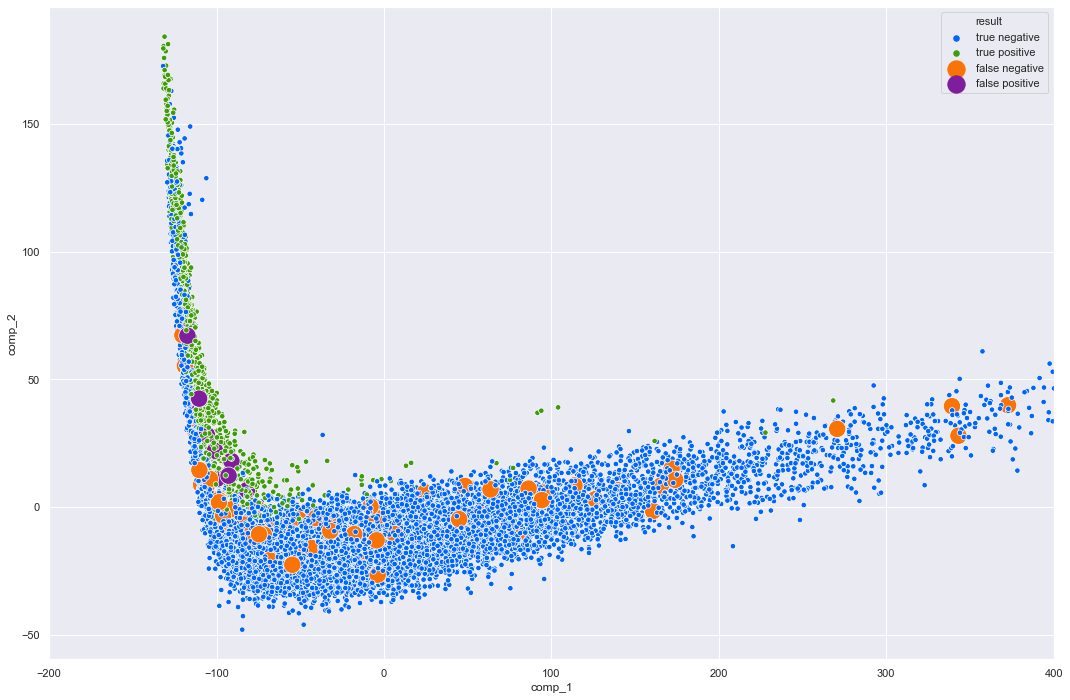

In [110]:
predictions_rf = rf_best.predict(X_train)
plot_results_2d(predictions_rf)
plt.savefig("predictions/rf_predictions.png")

This Random Forest is doing really well on the training data as the number of false positive and false negative have been reduced by half. However it may be overfitting somewhat. Estimated generalization error is still a bit better with this model than with RBF-SVM and Logistic Regression. Increasing the nb of estimators to 10000 didn't improve the test score further. 

In [112]:
list(zip(train_data.columns[:-1], rf_best.feature_importances_))

[('mu_ip', 0.16228260381820764),
 ('sigma_ip', 0.031087882127711745),
 ('kurtosis_ip', 0.4247712782959571),
 ('skewness_ip', 0.2379491871551796),
 ('mu_dmsnr', 0.053476274630177054),
 ('sigma_dmsnr', 0.04939173179399598),
 ('kurtosis_dmsnr', 0.02266822424008832),
 ('skewness_dmsnr', 0.018372817938682534)]

Looks like the most important feature are the integrated profile characteristics, mainly kurtosis and skewness. Dispersion measure signal-to-noise-ratio features have a low to moderate importance.